In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline
import numba
from pylab import *

In [2]:
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
 
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

In [118]:
L = 500
N = 200
x = np.arange(-int(L/2), int(L/2), 1)
y = np.arange(-int(L/2), int(L/2), 1)
sp = np.meshgrid(x, y)
v = 0.03
lamda=0.03
Fin=0.3/lamda
Tin=3/lamda
delta_theta=np.zeros(N)

##x represents coordinates, v has the components of the velocity (probably superfluous, psi is the orientation, omega is the 
##angular velocity and r is the radius.

particles_x=np.zeros([N,2])
particles_v = np.zeros([N, 2])
# particles_psi = np.random.uniform(-np.pi/4, np.pi/4, N)
particles_psi = np.random.normal(1, np.pi/4, N)
particles_omega = np.zeros(N)
particles_r = np.zeros(N)
F_x=np.zeros([N,N])
F_y=np.zeros([N,N])

In [119]:
for i in range (int(np.sqrt(N))):
    particles_x[10*i:10*(i+1), 0] = np.arange(0, 1,10)+np.random.uniform(-0.1, 0.1, 10)
    particles_x[10*i:10*(i+1), 1] = i
    
# for i in range (int(np.sqrt(N))):
#     particles_x[10*i:10*(i+1), 0] = np.arange(0, N , 10)+np.random.uniform(-0.1, 0.1, 10)
#     particles_x[:, 1] = i+np.random.uniform(-0.1, 0.1, 10)
    
# for i in range (int(N/10)):
#     particles_x[int(N/10)*i:int(N/10)*(i+1), 0] = np.arange(0, int(N/10),1) + np.random.uniform(-0.1, 0.1, int(N/10))
#     particles_x[int(N*i/10): int(N*(i+1)/10), 1] = np.arange(0, int(N/10),1) + np.random.uniform(-0.1, 0.1, int(N/10))
    
particles_r[:] = np.random.normal(1, 3/2, N)

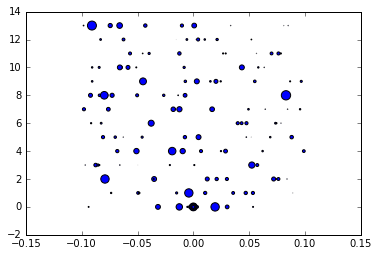

In [120]:

plt.scatter(particles_x[:, 0],particles_x[:,1],s=np.pi*(particles_r[:]**2))
# plt.savefig("K:/Maestria/Computational Physics/Collective dynamics/figures"+"/figures"+ str(0)+".png",dpi=600)

In [121]:
def update(N,L,particles_x, particles_r,particles_psi):
    # for me particles_psi is determined by the angles each particle has with the another particles, so the update function just need
    # the position and the radious of each particles
    theta_out = np.zeros(N)
    d_theta = np.zeros(N)
    theta_in=np.zeros(N)
    theta_noise = np.random.random(N)
    particles_omega = (v)/particles_r

    psi_diff = np.zeros([N, N])
    psi_diff = particles_psi[None, :] - particles_psi[:, None]                               
    
    ##distances and angles calculations
    
    # distances between the center of the particles considering its coordinates
    dist_components= particles_x[None, :, :] - particles_x[:, None, :]
    d = np.linalg.norm(dist_components, axis = 2)
    
    angles_all= np.arctan2(dist_components[:, :, 1], dist_components[:, :, 0])
    # condition to do not be neighbours,What I care is about the non-neighbours which do not contribute, so is easy to define
    d[d>2.7]=0
 
    psi_diff = psi_diff * d

    
# Setting how many particles will be in the boundary
        
    for i in range(N):
        ind=zip(*np.where(d[:,i]!=0))
        ind=list(ind)
        angles=np.zeros([len(ind)])
        if (len(ind))>3:
            for j in range(len(ind)):
                neigh=np.zeros(shape=(len(ind),2))
                neigh[j,:]=particles_x[ind[j],:]
                angles[j]=arctan2(neigh[j,1],neigh[j,0])
            m=np.amax(angles)-np.amin(angles)
            
            if abs(m)<np.pi:
                theta_in[i]=(1/2)*m
                theta_out[i] = 2*np.pi - 2*theta_in[i]
                particles_psi[:]=np.pi/2-np.amin(angles)
            
            
    for i in range (0, N):
            for j in range (0, N):
                d[i, j] -= particles_r[i] + particles_r[j]
    d[d<0] = 0 # when the particles do not overlap
    
    ##distances along different axes
    dx = d*np.cos(particles_psi[:])
    dy = d*np.sin(particles_psi[:])
    
    ##force calculations
   
    psi_diff = (particles_psi[None, :] - particles_psi[:, None])*d
    np.cos(theta_in)
#     F = 0.05 + (theta_out[:] - np.pi)*0.3*(theta_out[:]>np.pi)
    
    for i in range(N):
        F_x[i,:] = 0.05*np.cos(particles_psi[:])+(theta_out[:] - np.pi)*0.3*(theta_out[:]>np.pi)*np.cos(theta_in)-np.sum(d[:], axis =1)*np.cos(angles_all[:,i])
        F_y[i,:] = 0.05*np.sin(particles_psi[:])+(theta_out[:] - np.pi)*0.3*(theta_out[:]>np.pi)*np.sin(theta_in)-np.sum(d[:], axis =1)*np.cos(angles_all[:,i])
        
         #angular velocity and update of the positions
        particles_x[:, 0] = np.mod(particles_x[:, 0] + F_x[i,:],L)
        particles_x[:, 1] = np.mod(particles_x[:, 1] + F_y[i,:],L)
    

   
    ## Torque calculations

    T = 0.06*(theta_out[:]>np.pi) + 0.03*np.random.uniform(-1,1, N) + 0.5*np.sum(psi_diff, axis = 1)[:]
    
    particles_psi[:] = particles_psi[:]+T[:]
        

 
    return  particles_x,particles_psi

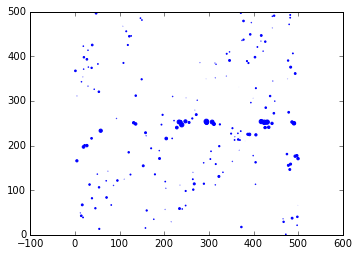

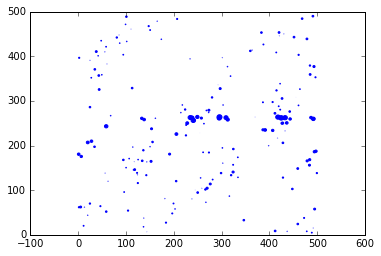

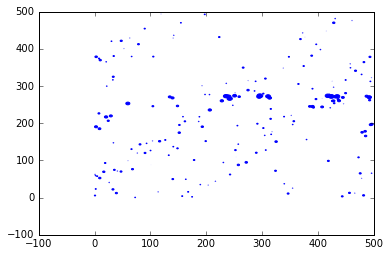

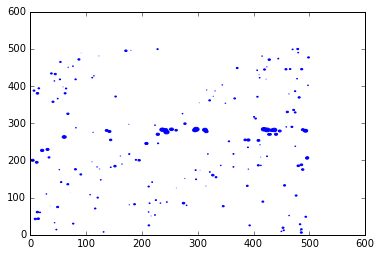

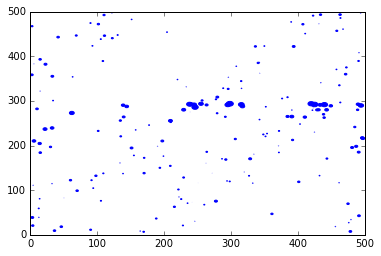

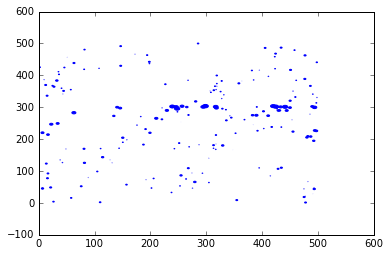

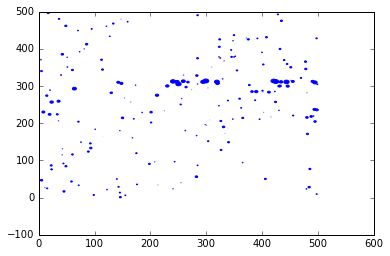

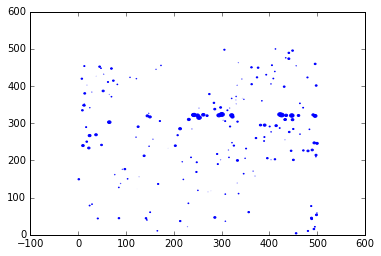

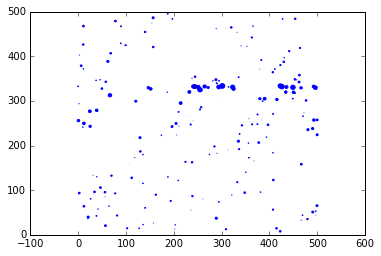

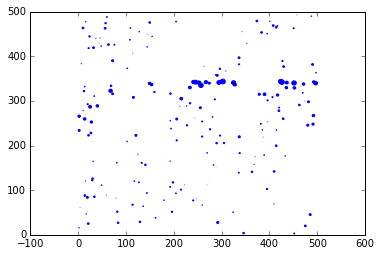

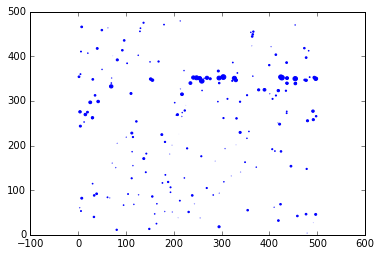

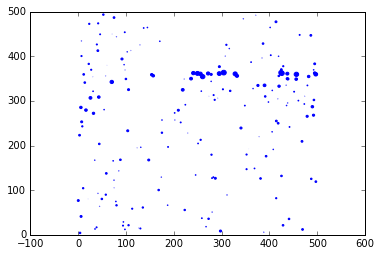

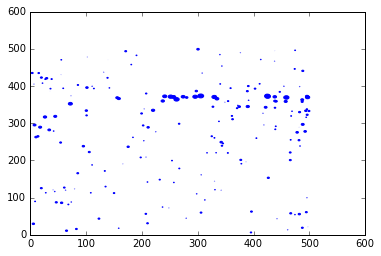

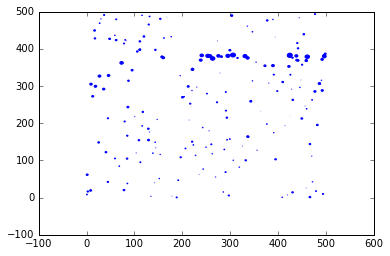

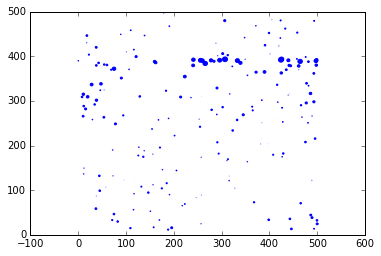

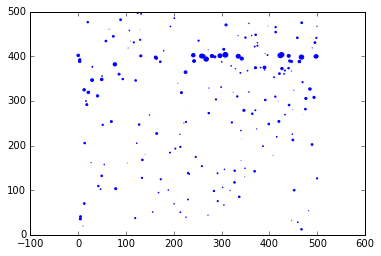

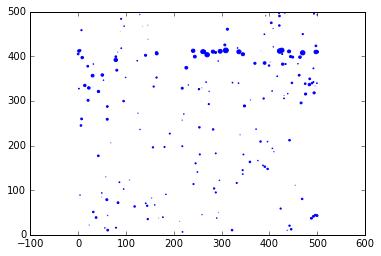

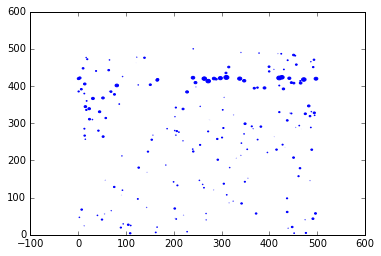

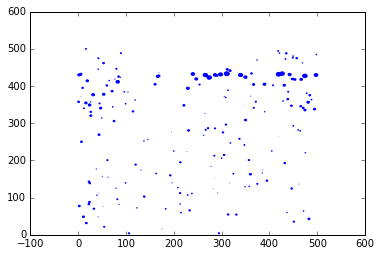

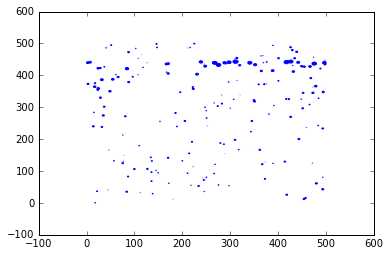

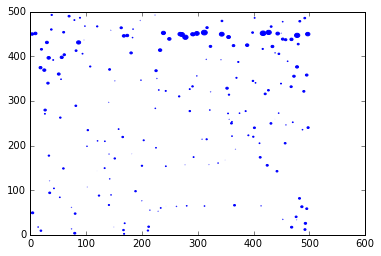

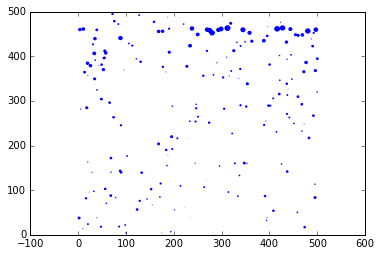

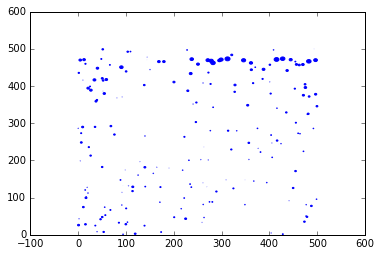

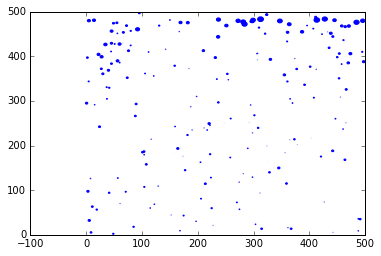

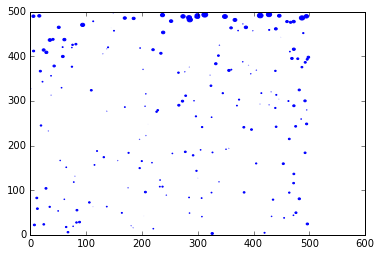

In [123]:


ax = subplot(aspect='equal')
for i in range(25):
    particles_x,particles_psi=update(N, L, particles_x, particles_r,particles_psi)
#     particle_x=particle.copy()
    circles(particles_x[:,0], particles_x[:, 1], particles_r)
    
#     figures=plt.scatter(particles_x[:, 0], particles_x[:, 1], s = np.pi*particles_r[:]**2)
#     plt.savefig("K:/Maestria/Computational Physics/Collective dynamics/figures"+"/figures"+ str(i+1)+".png",dpi=600)
    plt.show()
#     print(particles_x)
    


In [110]:
 np.random.uniform(-np.pi/4, np.pi/4, N)

array([-0.73098094,  0.48949883,  0.34491056,  0.47314448,  0.33573371,
       -0.02362474,  0.56165748,  0.13027468,  0.19366681,  0.59085173,
       -0.66824759,  0.30472703, -0.28521403, -0.13640892,  0.4023956 ,
        0.46146867, -0.23523899,  0.20014146,  0.47896078, -0.26034188,
        0.72861347,  0.41755965,  0.46002968, -0.0749514 , -0.72456728,
       -0.0586512 , -0.3151038 ,  0.38739572,  0.77178364,  0.62490761,
       -0.0670951 , -0.0589916 ,  0.08616507,  0.76753274, -0.16396809,
        0.57102301,  0.73469482, -0.05788492,  0.63378384, -0.0296446 ,
       -0.5750756 ,  0.5468021 ,  0.34096143,  0.52821895, -0.52598316,
       -0.29638811, -0.70544009,  0.43797446,  0.48603162,  0.62748616,
        0.46003285,  0.70840862, -0.22494071, -0.50397583,  0.65116937,
       -0.01020986,  0.15566617, -0.26212551, -0.57628673,  0.63142798,
        0.60024819, -0.73824239,  0.74410983, -0.71315767,  0.54051609,
        0.394386  ,  0.25459974, -0.06018516,  0.32949351,  0.49

In [50]:
s = np.pi*particles_r[:]**2
figure(figsize=(6,4))
ax = subplot(aspect='equal')

#plot a set of circle
a=particles_x[:, 0]

out = circles(a, particles_x[:, 1], particles_r, alpha=0.5, ec='none')
out.savefig('K:\Maestria\Computational Physics\Collective dynamics\figures'+str(i))
# colorbar() 
#or colorbar(out)


# plt.scatter(particles_x[:, 0], particles_x[:, 1], s = np.pi*particles_r[:]**2)
# plt.show()

TypeError: 'PathCollection' object is not callable

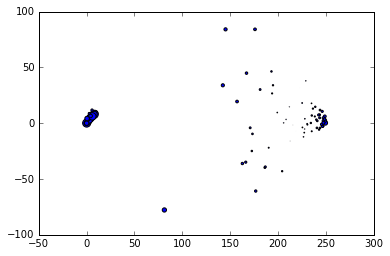

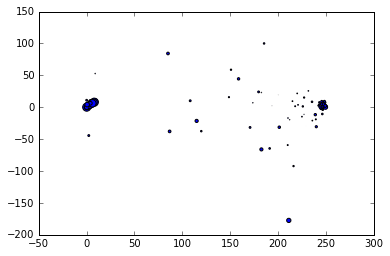

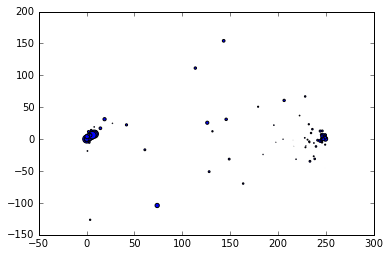

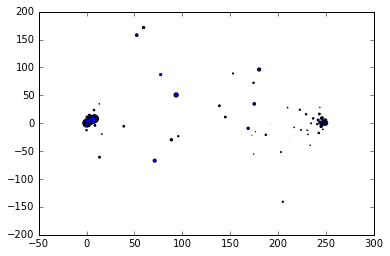

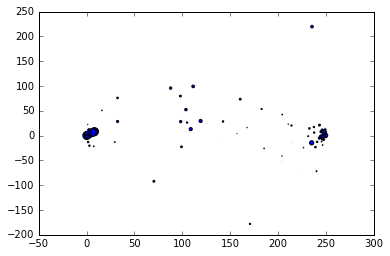

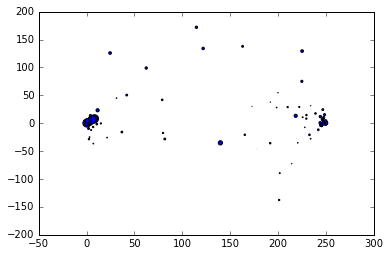

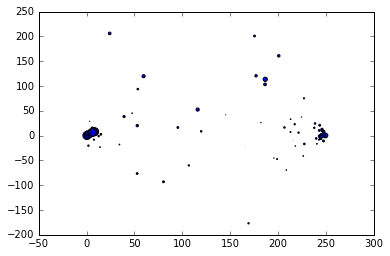

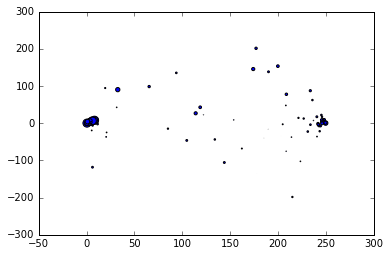

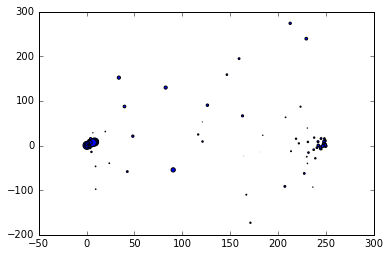

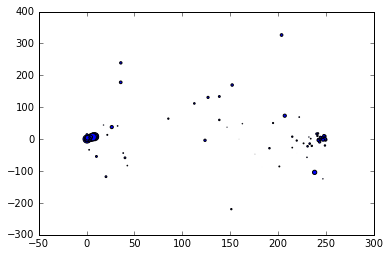

In [161]:
for i in range(10):
    particles_x,particles_psi=update(N, L, particles_x, particles_r,particles_psi)
#     particle_x=particle.copy()
    plt.scatter(particles_x[:, 0], particles_x[:, 1], s = np.pi*particles_r[:]**2)
    plt.show()